In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_magjudge')
save_params_folder = op.join(bids_folder,'derivatives/phenotype')

sns.set_context('talk')

from utils import get_data

df = get_data(bids_folder, include_var=['group','age'])
df['x'] = df['log(n2/n1)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']].set_index('subject')


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [32]:
model_label = 1
model = bambi.Model('chose_n2 ~ x + x*group + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [2]:
model_label = 2
model = bambi.Model('chose_n2 ~ x + x*n1*group + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [2]:
model_label = 3
model = bambi.Model('chose_n2 ~ x + x*C(n1)*group + (x*C(n1)|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [ ]:
model_label = 4

model = bambi.Model('chose_n2 ~ x + n1 + n1:x + x:age + group:n1 + x:group:age + x:group:n1 + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [ ]:
model_label = 5

model = bambi.Model('chose_n2 ~ x + n1 + group + x:group + x:n1 + x:age + group:n1 + x:group:age + x:group:n1 + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [ ]:
model_label = 'startSimple1'

model = bambi.Model('chose_n2 ~ x + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [95]:
model_label = 'startSimple2' # not hierachical to get subjectwise gammas --> look at age and IQ effects

model = bambi.Model('chose_n2 ~ 0 + C(subject) + x:C(subject)', link='probit', family='bernoulli', data=df.reset_index())

### fit

In [96]:
import arviz as az

traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

az.to_netcdf(traces, op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))

Modeling the probability that chose_n2==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C(subject), x:C(subject)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.


'/Users/mrenke/data/ds-dnumrisk/derivatives/cogmodels_magjudge/probit_model-startSimple2_trace.netcdf'

### load in trace

In [3]:
import arviz as az

model_label = 2

traces = az.from_netcdf( op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))


2
Intercept: mean=-0.40437366242013745, 95%CI=[-0.53631341 -0.27289071]
x: mean=5.328738339794891, 95%CI=[4.78816969 5.8702809 ]
n1: mean=0.03426855188141974, 95%CI=[0.02425891 0.04460338]
x:n1: mean=-0.10129796960244809, 95%CI=[-0.13040064 -0.07223313]
group: mean=-0.09859768587327673, 95%CI=[-0.28514108  0.09107274]
x:group: mean=-0.5751384399598628, 95%CI=[-1.30818567  0.16105182]
n1:group: mean=0.013102677868606508, 95%CI=[-0.00106698  0.02753195]
x:n1:group: mean=0.02962000773530566, 95%CI=[-0.01101106  0.06960666]


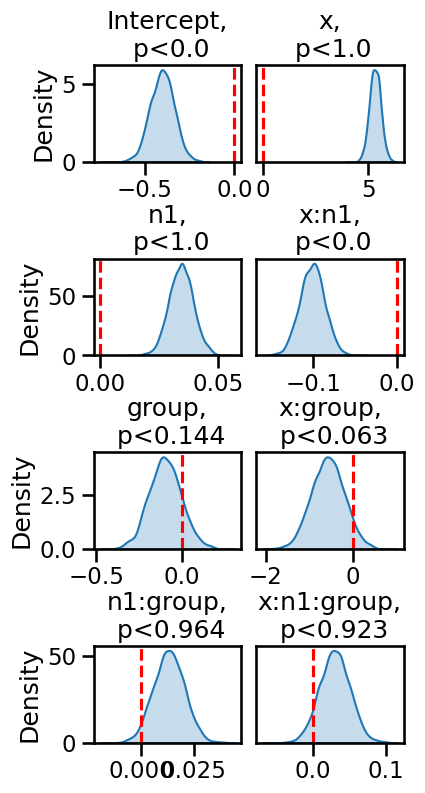

In [25]:
print(model_label)

variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,n_rows * 2.2), sharex=False)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=1)
plt.savefig(op.join(plot_folder, f'probit_model-{model_label}_regressors.pdf'))

### group level

In [ ]:
from utils import extract_ip_precision

intercept, gamma= extract_rnp_precision(traces, model,df, group_level = True) # ,group=False for subs
intercept = intercept.stack([1, 2])
intercept.columns = ['intercept']
gamma = gamma.stack([1, 2])
gamma.columns = ['gamma']

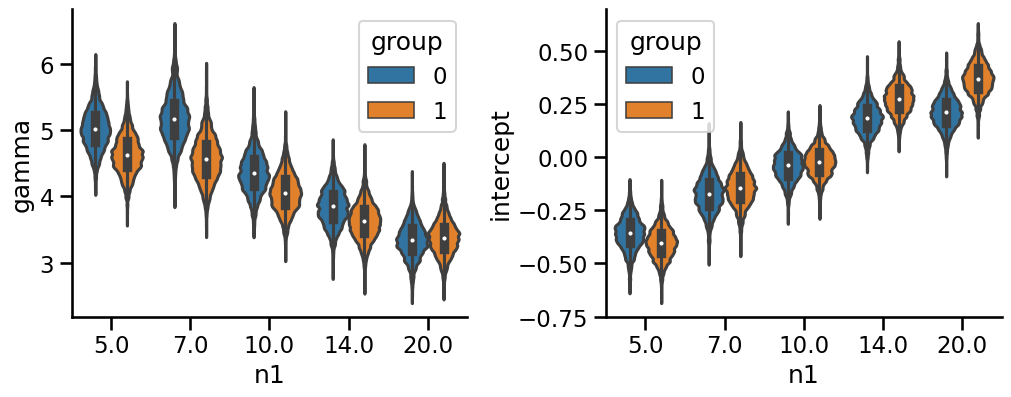

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(data=gamma.reset_index(), x='n1',y='gamma',hue='group',ax=axs[0])
sns.violinplot(data=intercept.reset_index(), x='n1',y='intercept',hue='group',ax=axs[1])
plt.subplots_adjust(wspace=0.35)
sns.despine()


Text(51.0, 0.5, 'density - gamma')

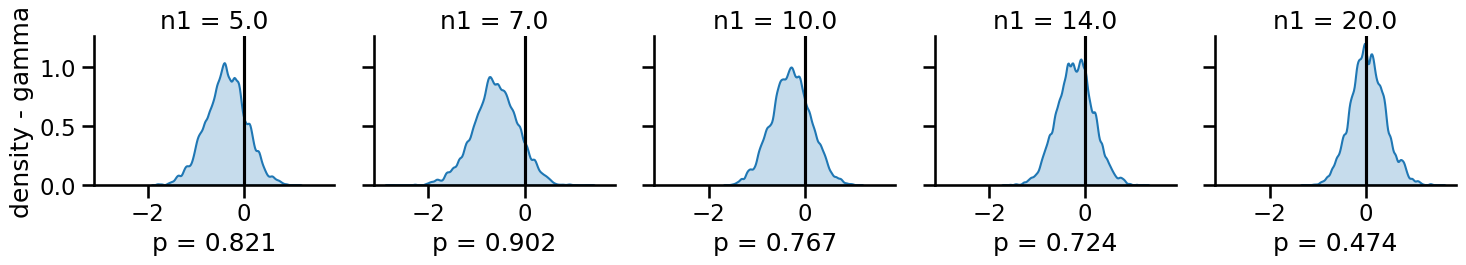

In [6]:
temp = gamma.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')

for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - gamma')


Text(51.0, 0.5, 'density - intercept')

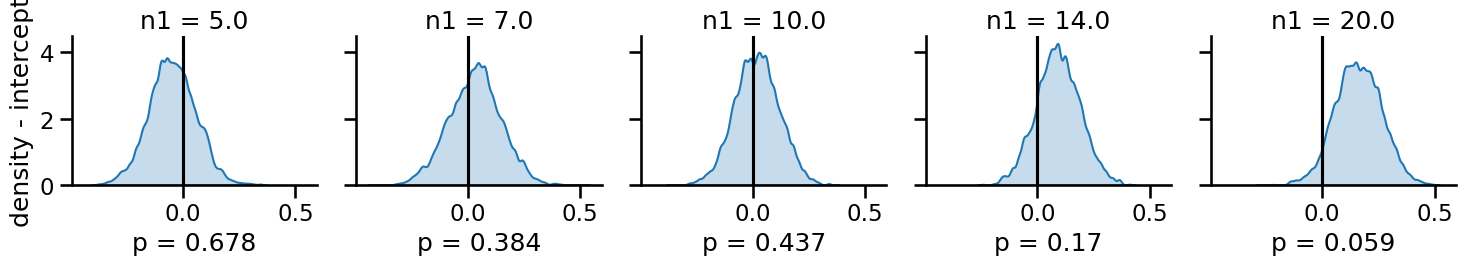

In [7]:
temp = intercept.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')


for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - intercept')


#### subject level

In [111]:
from utils import extract_rnp_precision

intercept, gamma= extract_rnp_precision(traces, model,df, group_level = False) # ,group=False for subs
ip = np.clip(np.exp(intercept/gamma), 0, 1) # indiff point, similar to rnp
ip = ip.stack([1,2])
ip.columns = ['ip']

intercept = intercept.stack([1, 2])
intercept.columns = ['intercept']
intercept= [intercept.xs([sub, group], level=['subject', 'group']) for sub, group in group_list.itertuples()] # subject must be in index!
intercept = pd.concat(intercept, keys=group_list.index, names=['subject'])
gamma = gamma.stack([1, 2])
gamma.columns = ['gamma'] # only sample from appropriate group for respective subject
gamma= [gamma.xs([sub, group], level=['subject', 'group']) for sub, group in group_list.itertuples()]
gamma = pd.concat(gamma, keys=group_list.index, names=['subject'])

/Users/mrenke/mambaforge/envs/behav_fit2_copy/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_33730/3111972063.py:10: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  intercept= [intercept.xs([sub, group], level=['subject', 'group']) for sub, group in group_list.itertuples()] # subject must be in index!
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_33730/3111972063.py:14: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  gamma= [gamma.xs([sub, group], level=['subject', 'group']) for sub, group in group_list.itertuples()]


In [ ]:
sub_n1effect = traces.posterior['n1|subject'].to_dataframe().rename_axis(index={'subject__factor_dim':'subject'})
sub_n1effect = sub_n1effect.reset_index('subject')
sub_n1effect['subject'] = sub_n1effect['subject'].astype(int)
sub_n1effect = sub_n1effect.set_index('subject',append=True)
sub_n1effect = sub_n1effect.join(group_list, on='subject').set_index('group', append=True)

df_n1 = sub_n1effect.join(traces.posterior['n1'].to_dataframe()).join(traces.posterior['n1:group'].to_dataframe())
df_n1['n1_slope'] = df_n1['n1'] + df_n1['n1|subject']
df_n1.loc[df_n1.index.get_level_values('group') == 1, 'n1_slope'] += df_n1['n1:group']

#df_n1.groupby(['subject','group']).mean()[['n1_slope']].to_csv(op.join(save_params_folder, 'magjudge_n1-Slopes-subwise_probit-2.csv'))

In [114]:
# save subwise params
params_comb = gamma.groupby('subject').mean().join(intercept.groupby('subject').mean()).join(df_n1.groupby('subject').mean()[['n1_slope']])
params_comb.to_csv(op.join(save_params_folder, 'probit-2_all-subwise-params_appropSample.csv'))

0.01310267786860651


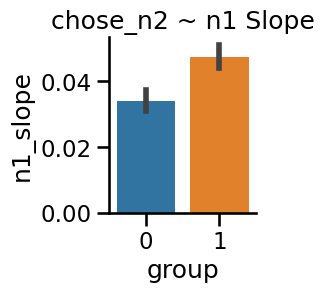

In [102]:
tmp = df_n1.groupby(['subject','group']).mean()
sns.catplot(data=tmp.reset_index(), x='group', y='n1_slope', kind='bar',height=3, aspect=1)
plt.title('chose_n2 ~ n1 Slope')
print(df_n1['n1:group'].mean())


#### other ways to get "working memory effect"

In [ ]:
from itertools import product

n_chains = ip.index.unique('chain').values
n_draws = ip.index.unique('draw').values
subjects = ip.index.unique('subject').values

index = pd.MultiIndex.from_product([subjects, n_chains, n_draws ], names=['subject','chain', 'draw'])
df_ss = pd.DataFrame(index=index, columns=['slope', 'intercept'])

for chain, draw in product(n_chains, n_draws):
    ip_sample = ip.xs(chain, level='chain').xs(draw, level='draw').reset_index('n1')

    for sub in subjects:
        group = group_list.loc[sub].values[0] # # only sample from appropriate group for respective subject
        tmp = ip_sample.xs([sub, group], level=['subject', 'group']) 
        tmp = ip_sample.xs(sub,0,level='subject') #

        A = np.vstack([tmp['n1'], np.ones(len(tmp))]).T
        slope, intercept = np.linalg.lstsq(A, tmp['ip'], rcond=None)[0]
        df_ss.loc[(sub, chain, draw), 'slope'] = slope
        df_ss.loc[(sub, chain, draw), 'intercept'] = intercept
# does not seem to work... , dyscalcs should have a higher slope (IP~n1)

Text(0.5, 1.0, 'IP~n1 Slope')

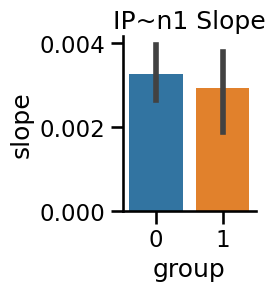

In [106]:
tmp = df_ss.join(group_list).set_index('group',append=True).groupby(['subject','group']).mean()
tmp.head()
sns.catplot(data=tmp.reset_index(), x='group', y='slope', kind='bar',height=3, aspect=1)
plt.title('IP~n1 Slope')

In [34]:
rnp = pd.DataFrame(np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1), columns=['rnp'])
rnp.head()

/Users/mrenke/mambaforge/envs/behav_fit2_copy/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


rnp
subject n1   chain draw     
13      14.0 0     0     1.0
                   1     1.0
                   2     1.0
                   3     1.0
                   4     1.0

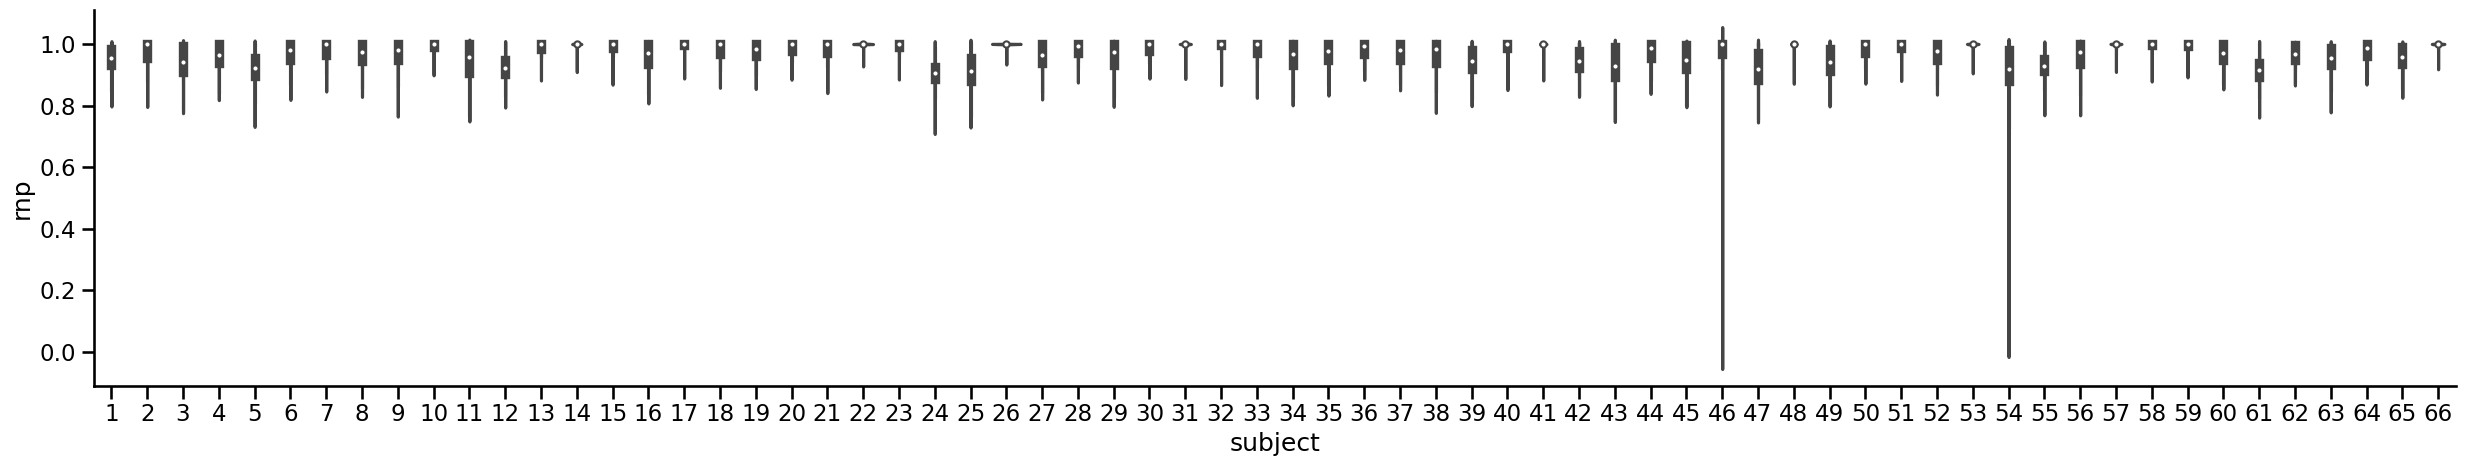

In [35]:
fac = sns.catplot(x='subject', y='rnp', data=rnp.reset_index(), aspect=5., kind='violin')


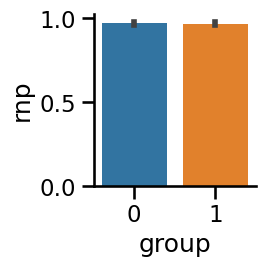

In [50]:
tmp = rnp.join(group_list.set_index('subject'), on='subject').set_index('group', append=True)
tmp = tmp.groupby(['subject','group']).mean()
sns.catplot(data=tmp.reset_index(), x='group', y='rnp', kind='bar',height=3, aspect=1)

In [44]:
sub_n1effect = traces.posterior['n1|subject'].to_dataframe().rename_axis(index={'subject__factor_dim':'subject'})
sub_n1effect = sub_n1effect.reset_index('subject')
sub_n1effect['subject'] = sub_n1effect['subject'].astype(int)
sub_n1effect = sub_n1effect.set_index('subject',append=True)
sub_n1effect = sub_n1effect.join(group_list.set_index('subject'), on='subject').set_index('group', append=True)

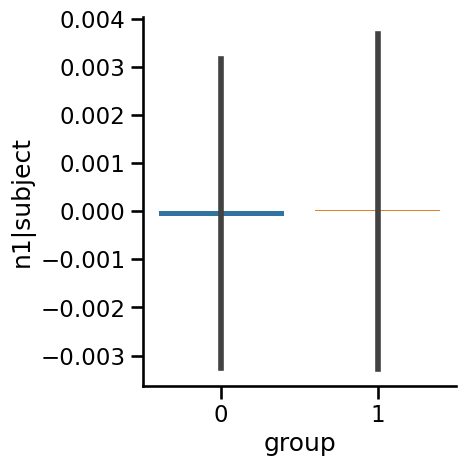

In [46]:
tmp = sub_n1effect.groupby(['subject','group']).mean()
sns.catplot(data=tmp.reset_index(), x='group', y='n1|subject', kind='bar')

## PPCs

In [34]:
def format_bambi_ppc(trace, model, df):

    preds = []
    for key, kind in zip(['ll_bernoulli', 'p'], ['pps', 'mean']):
        pred = model.predict(trace, kind=kind, inplace=False) 
        if kind == 'pps':
            pred = pred['posterior_predictive']['chose_n2'].to_dataframe().unstack(['chain', 'draw'])['chose_n2']
        else:
            pred = pred['posterior']['chose_n2_mean'].to_dataframe().unstack(['chain', 'draw'])['chose_n2_mean']
        pred.index = df.index
        pred = pred.set_index(pd.MultiIndex.from_frame(df), append=True)
        preds.append(pred)

    pred = pd.concat(preds, keys=['ll_bernoulli', 'p'], names=['variable'])
    return pred

In [ ]:
from utils_03 import  summarize_ppc, plot_ppc, format_bambi_ppc

ppc = format_bambi_ppc(traces, model, df)
summarize_ppc(ppc, groupby=None)


In [ ]:
level = 'group' # 'subject'
for plot_type in [1,2,3]:
    plot_ppc(df, ppc,level=level, plot_type=plot_type)
    plt.savefig(op.join(plot_folder, f'ppc_rnp_model-{model_label}_plot-{plot_type}_{level}.pdf'))
    plt.close()